In [3]:
import os
import git
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")
main_df = main_df.copy()
np.random.seed(0)

# KS Stat (r, eta) & (r, 1/beta) Point Plots

In [5]:
fontsize = 15
markersize = 10
labelsize = 15
markertypes = ['x', 'D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha\geq0.05$', r'$\alpha\geq0.10$']
points = [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [
    Rectangle((0, 0), 1, 1, color='black', alpha=0.1),
    Rectangle((0, 0), 1, 1, color='black', alpha=0.3),
]

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}

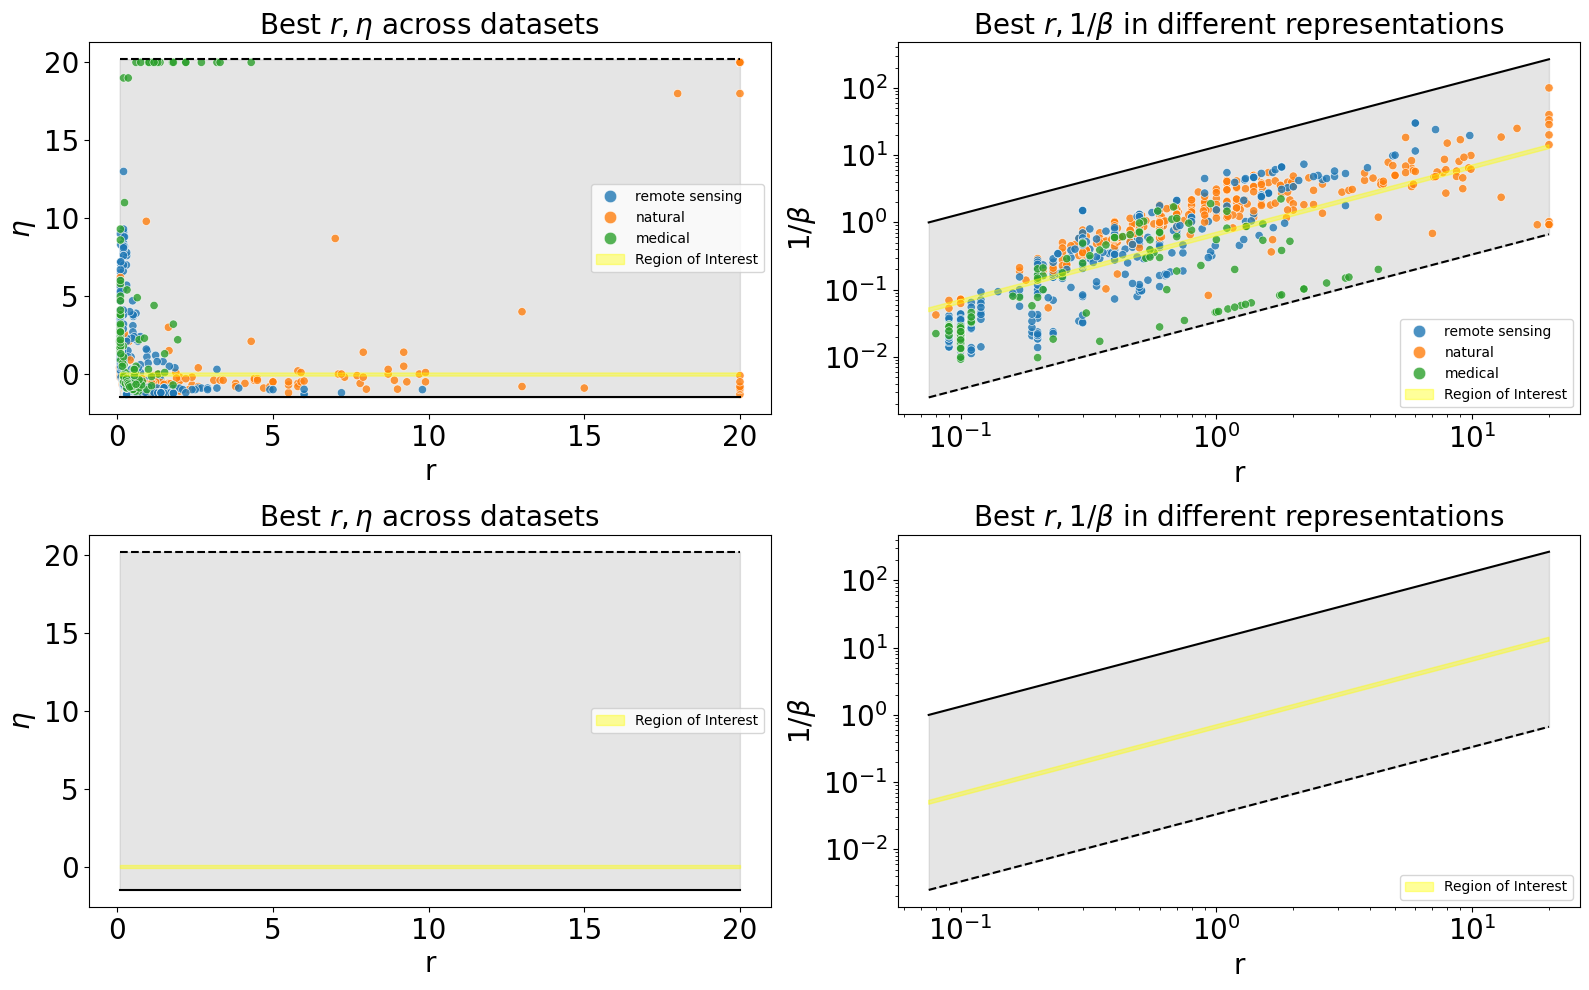

In [6]:
temp = main_df.copy() #[(main_df['dataset'] == 'pastis') | (main_df['dataset'] == 'agriVision') | (main_df['dataset'] == 'spaceNet')]
r_valid = (temp['best_r'].min() - 0.005, temp['best_r'].max())
eta_valid = (-1.5, 20.2)
r_roi = (temp['best_r'].min() - 0.005, temp['best_r'].max())
eta_roi = (-0.1, 0.1)
log_scale = True

r_vals = np.linspace(r_valid[0], r_valid[1], 1001)
beta_vals_above = 1 / (3 / (2 * r_vals) / 20)
beta_vals_below = 1 / (3 / (2 * r_vals) * 20)

r_vals_roi = np.linspace(r_roi[0], r_roi[1], 1001)
beta_vals_roi_above = 1 / (3 / (2 * r_vals_roi) / 0.1)
beta_vals_roi_below = 1 / (3 / (2 * r_vals_roi) * (-0.1))

r_shade_roi = np.linspace(*r_roi, 100)
eta_shade_roi = np.linspace(*eta_roi, 100)

# Define Region of Interest borders in r-eta space
x_border = [r_shade_roi[0], r_shade_roi[-1], r_shade_roi[-1], r_shade_roi[0], r_shade_roi[0]]
y_border = [eta_shade_roi[0], eta_shade_roi[0], eta_shade_roi[-1], eta_shade_roi[-1], eta_shade_roi[0]]

# Calculate Region of Interest borders in r-(1/beta) space
beta_border = (np.array(y_border) + 1.5) / np.array(x_border)
x_border_beta = x_border
y_border_beta = 1 / beta_border

# Plot the Region of Interest in all 4 plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# First plot (top left): r-eta space
axes[0, 0].fill_between(r_vals, y1=eta_valid[0], y2=eta_valid[1], color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='dataset_type', ax=axes[0, 0], alpha=0.8)
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[0, 0])
sns.lineplot(x=r_vals, y=eta_valid[1], color='black', ax=axes[0, 0], linestyle="--")
axes[0, 0].fill_between(r_vals_roi, eta_roi[0], eta_roi[1], color='yellow', alpha=0.4, label="Region of Interest")
axes[0, 0].set_title(r'Best $r, \eta$ across datasets', fontsize=20)
axes[0, 0].set_xlabel("r", fontsize=20)
axes[0, 0].set_ylabel(r'$\eta$', fontsize=20)
axes[0, 0].tick_params(axis='both', which='major', labelsize=20)
axes[0, 0].legend(markerscale=1.5, fontsize=10, loc='center right')

# Second plot (top right): r-(1/beta) space
axes[0, 1].fill_between(r_vals, beta_vals_above, beta_vals_below, color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_1/beta', hue='dataset_type', ax=axes[0, 1], alpha=0.8)
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=axes[0, 1])
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=axes[0, 1], linestyle="--")
axes[0, 1].fill(x_border_beta, y_border_beta, color='yellow', alpha=0.4, label="Region of Interest")
axes[0, 1].set_title(r'Best $r, 1/\beta$ in different representations', fontsize=20)
axes[0, 1].set_xlabel("r", fontsize=20)
axes[0, 1].set_ylabel(r'$1/\beta$', fontsize=20)
axes[0, 1].tick_params(axis='both', which='major', labelsize=20)
if log_scale:
    axes[0, 1].set_xscale('log')
    axes[0, 1].set_yscale('log')
axes[0, 1].legend(markerscale=1.5, fontsize=10, loc='lower right')

# Third plot (bottom left): r-eta space with failure categories
axes[1, 0].fill_between(r_vals, y1=eta_valid[0], y2=eta_valid[1], color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='failure_category', ax=axes[1, 0], alpha=0.8)
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[1, 0])
sns.lineplot(x=r_vals, y=eta_valid[1], color='black', ax=axes[1, 0], linestyle="--")
axes[1, 0].fill(x_border, y_border, color='yellow', alpha=0.4, label="Region of Interest")
axes[1, 0].set_title(r'Best $r, \eta$ across datasets', fontsize=20)
axes[1, 0].set_xlabel("r", fontsize=20)
axes[1, 0].set_ylabel(r'$\eta$', fontsize=20)
axes[1, 0].tick_params(axis='both', which='major', labelsize=20)
axes[1, 0].legend(markerscale=1.5, fontsize=10, loc='center right')

# Fourth plot (bottom right): r-(1/beta) space with failure categories
axes[1, 1].fill_between(r_vals, beta_vals_below, beta_vals_above, color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_1/beta', hue='failure_category', ax=axes[1, 1], alpha=0.8)
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=axes[1, 1], linestyle="--")
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=axes[1, 1])
axes[1, 1].fill(x_border_beta, y_border_beta, color='yellow', alpha=0.4, label="Region of Interest")
axes[1, 1].set_title(r'Best $r, 1/\beta$ in different representations', fontsize=20)
axes[1, 1].set_xlabel("r", fontsize=20)
axes[1, 1].set_ylabel(r'$1/\beta$', fontsize=20)
axes[1, 1].tick_params(axis='both', which='major', labelsize=20)
if log_scale:
    axes[1, 1].set_xscale('log')
    axes[1, 1].set_yscale('log')
axes[1, 1].legend(markerscale=1.5, fontsize=10, loc='lower right')

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "type_best_r_eta_beta_panel_plot.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

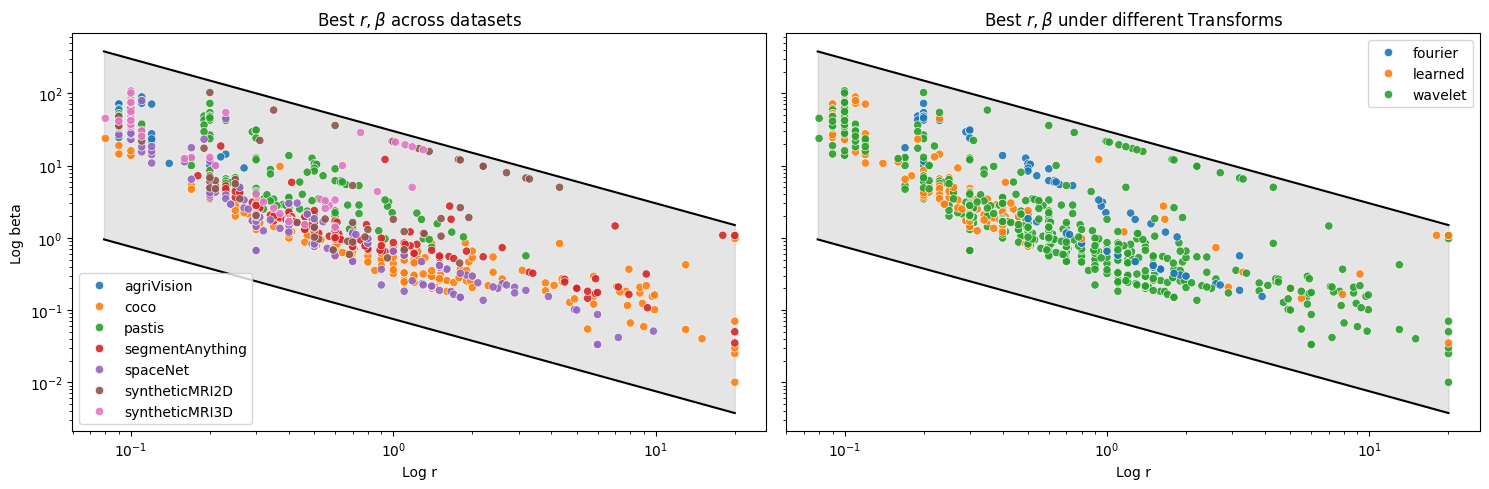

In [7]:
temp = main_df
log_scale = True
r_vals = np.linspace(temp['best_r'].min() - 0.001, temp['best_r'].max(), 1001)
beta_vals = 3 / (2 * r_vals) / 20

r_vals_2 = np.linspace(temp['best_r'].min() - 0.001,  temp['best_r'].max(), 1001)
beta_vals_2 = 3 / (2 * r_vals_2) * 20

# Create figure with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# First plot
ax1.fill_between(r_vals, beta_vals, beta_vals_2, color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='dataset', ax=ax1, alpha=0.9)
sns.lineplot(x=r_vals, y=beta_vals, color='black', ax=ax1)
sns.lineplot(x=r_vals_2, y=beta_vals_2, color='black', ax=ax1)
ax1.set_title(r'Best $r, \beta$ across datasets')
if log_scale:
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel('Log beta')
    ax1.set_xlabel('Log r')

# Second plot
ax2.fill_between(r_vals, beta_vals, beta_vals_2, color='gray', alpha=0.2)
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='transform', ax=ax2, alpha=0.9)
sns.lineplot(x=r_vals, y=beta_vals, color='black', ax=ax2)
sns.lineplot(x=r_vals_2, y=beta_vals_2, color='black', ax=ax2)
# Shade the region above the line

ax2.set_title(r'Best $r, \beta$ under different Transforms')
if log_scale:
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    # Remove y-label from second plot since it's shared
    ax2.set_ylabel('')
    ax2.set_xlabel('Log r')

plt.tight_layout()
plt.show()


# KS Stats Across Priors

In [8]:
statistical_cutoffs = -np.arange(1, 13, 2) # -np.hstack([np.arange(1, 13, 2), np.arange(14, 30, 2), np.arange(30, 100, 5)]) # -np.array([x**2 for x in range(1, 8)]) #np.arange(1, 40, 5)

for i in statistical_cutoffs:
    alpha = 10.0**i
    main_df[f'kstest_stat_cutoff_{i}'] = np.nan_to_num(stats.kstwo(n=main_df['total_samples']).isf(alpha))

alphas = np.linspace(0.1, 0.4, len(statistical_cutoffs))
alphas, [10.0**i for i in list(statistical_cutoffs)]

c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning:

(array([0.1 , 0.16, 0.22, 0.28, 0.34, 0.4 ]),
 [0.1, 0.001, 1e-05, 1e-07, 1e-09, 1e-11])

## Remote Sensing

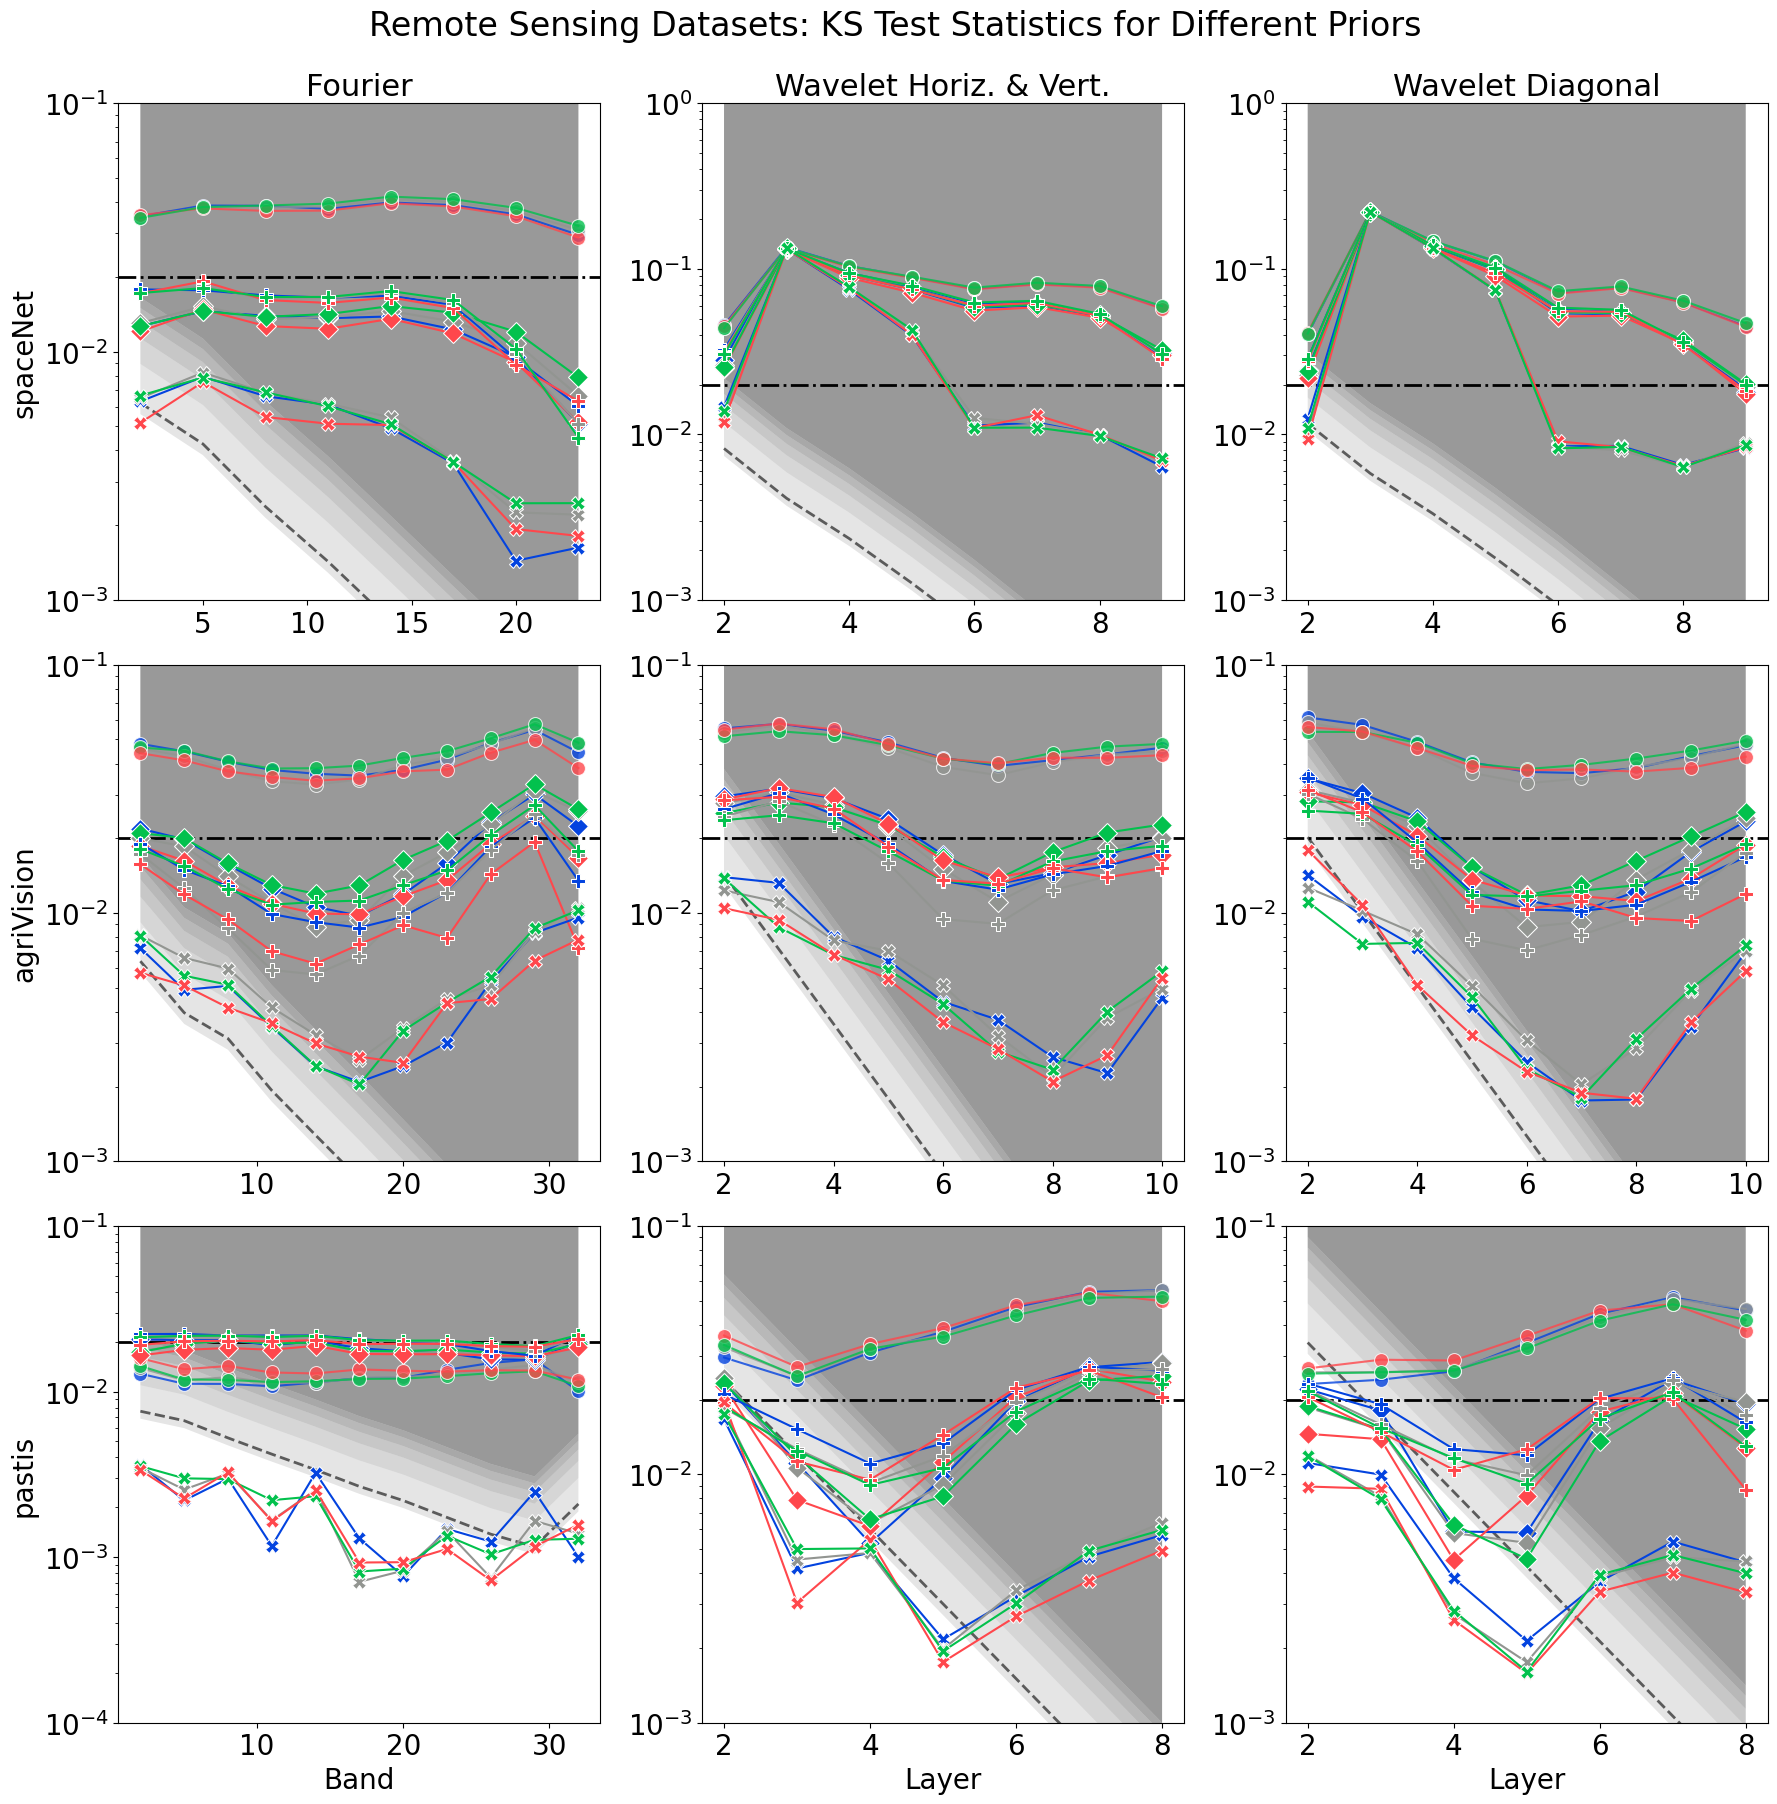

In [9]:
hue = 'channel'
fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}
toggle_markeredgecolor = True  # Set to True to enable markeredgecolor, False to disable
log_scale = not False
datasets_to_include = ['spaceNet', 'agriVision', 'pastis']  # List of datasets to include
num_datasets = len(datasets_to_include)
practical_pass = 0.02
marker_size = 10 
fontsize = 20

fig, axes = plt.subplots(num_datasets, 3, figsize=(18, 6 * num_datasets), sharey=False)


fig.suptitle("Remote Sensing Datasets: KS Test Statistics for Different Priors", y=1, fontsize=fontsize+4)

for i, dataset_name in enumerate(datasets_to_include):
    hue = 'channel'
    fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}

    if log_scale:
        axes[i, 0].set_yscale('log')
        axes[i, 1].set_yscale('log')
        axes[i, 2].set_yscale('log')

    # LEFT PLOT
    transform = 'fourier'
    GROUP_NAME = 'Band'
    dataset_filter = (main_df['dataset'] == dataset_name)
    transform_filter = (main_df['transform'] == transform)
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')
    
    # Region
    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 0].set_ylim(y_limits) 

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 0].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 0].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)
    
    # alpha=0.05
    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 0])
    
    # ks = 0.02
    axes[i, 0].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    # results
    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 0].set_xlabel("", fontsize=fontsize)
    axes[i, 0].set_ylabel(f"{dataset_name}", fontsize=fontsize)
    axes[i, 0].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 0].tick_params(axis='both', which='major', labelsize=fontsize)
    
    # MIDDLE PLOT
    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'horizVert')
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 1].set_ylim(y_limits)  

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 1].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 1].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)

    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 1])

    axes[i, 1].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)
    
    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 1].set_xlabel("", fontsize=fontsize)
    axes[i, 1].set_ylabel("", fontsize=fontsize)
    axes[i, 1].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 1].tick_params(axis='both', which='major', labelsize=fontsize)
   
    # RIGHT PLOT
    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'diagonal')
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 2].set_ylim(y_limits)

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 2].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 2].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)


    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 2])

    axes[i, 2].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 2].set_xlabel("", fontsize=fontsize)
    axes[i, 2].set_ylabel("", fontsize=fontsize)
    axes[i, 2].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 2].tick_params(axis='both', which='major', labelsize=fontsize)

axes[0, 0].set_title(f"Fourier", fontsize=fontsize+2)
axes[0, 1].set_title(f"Wavelet Horiz. & Vert.", fontsize=fontsize+2)
axes[0, 2].set_title(f"Wavelet Diagonal", fontsize=fontsize+2)

axes[2, 0].set_xlabel("Band", fontsize=fontsize)
axes[2, 1].set_xlabel("Layer", fontsize=fontsize)
axes[2, 2].set_xlabel("Layer", fontsize=fontsize)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "remote_sensing_ksstats.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')


# Natural Images

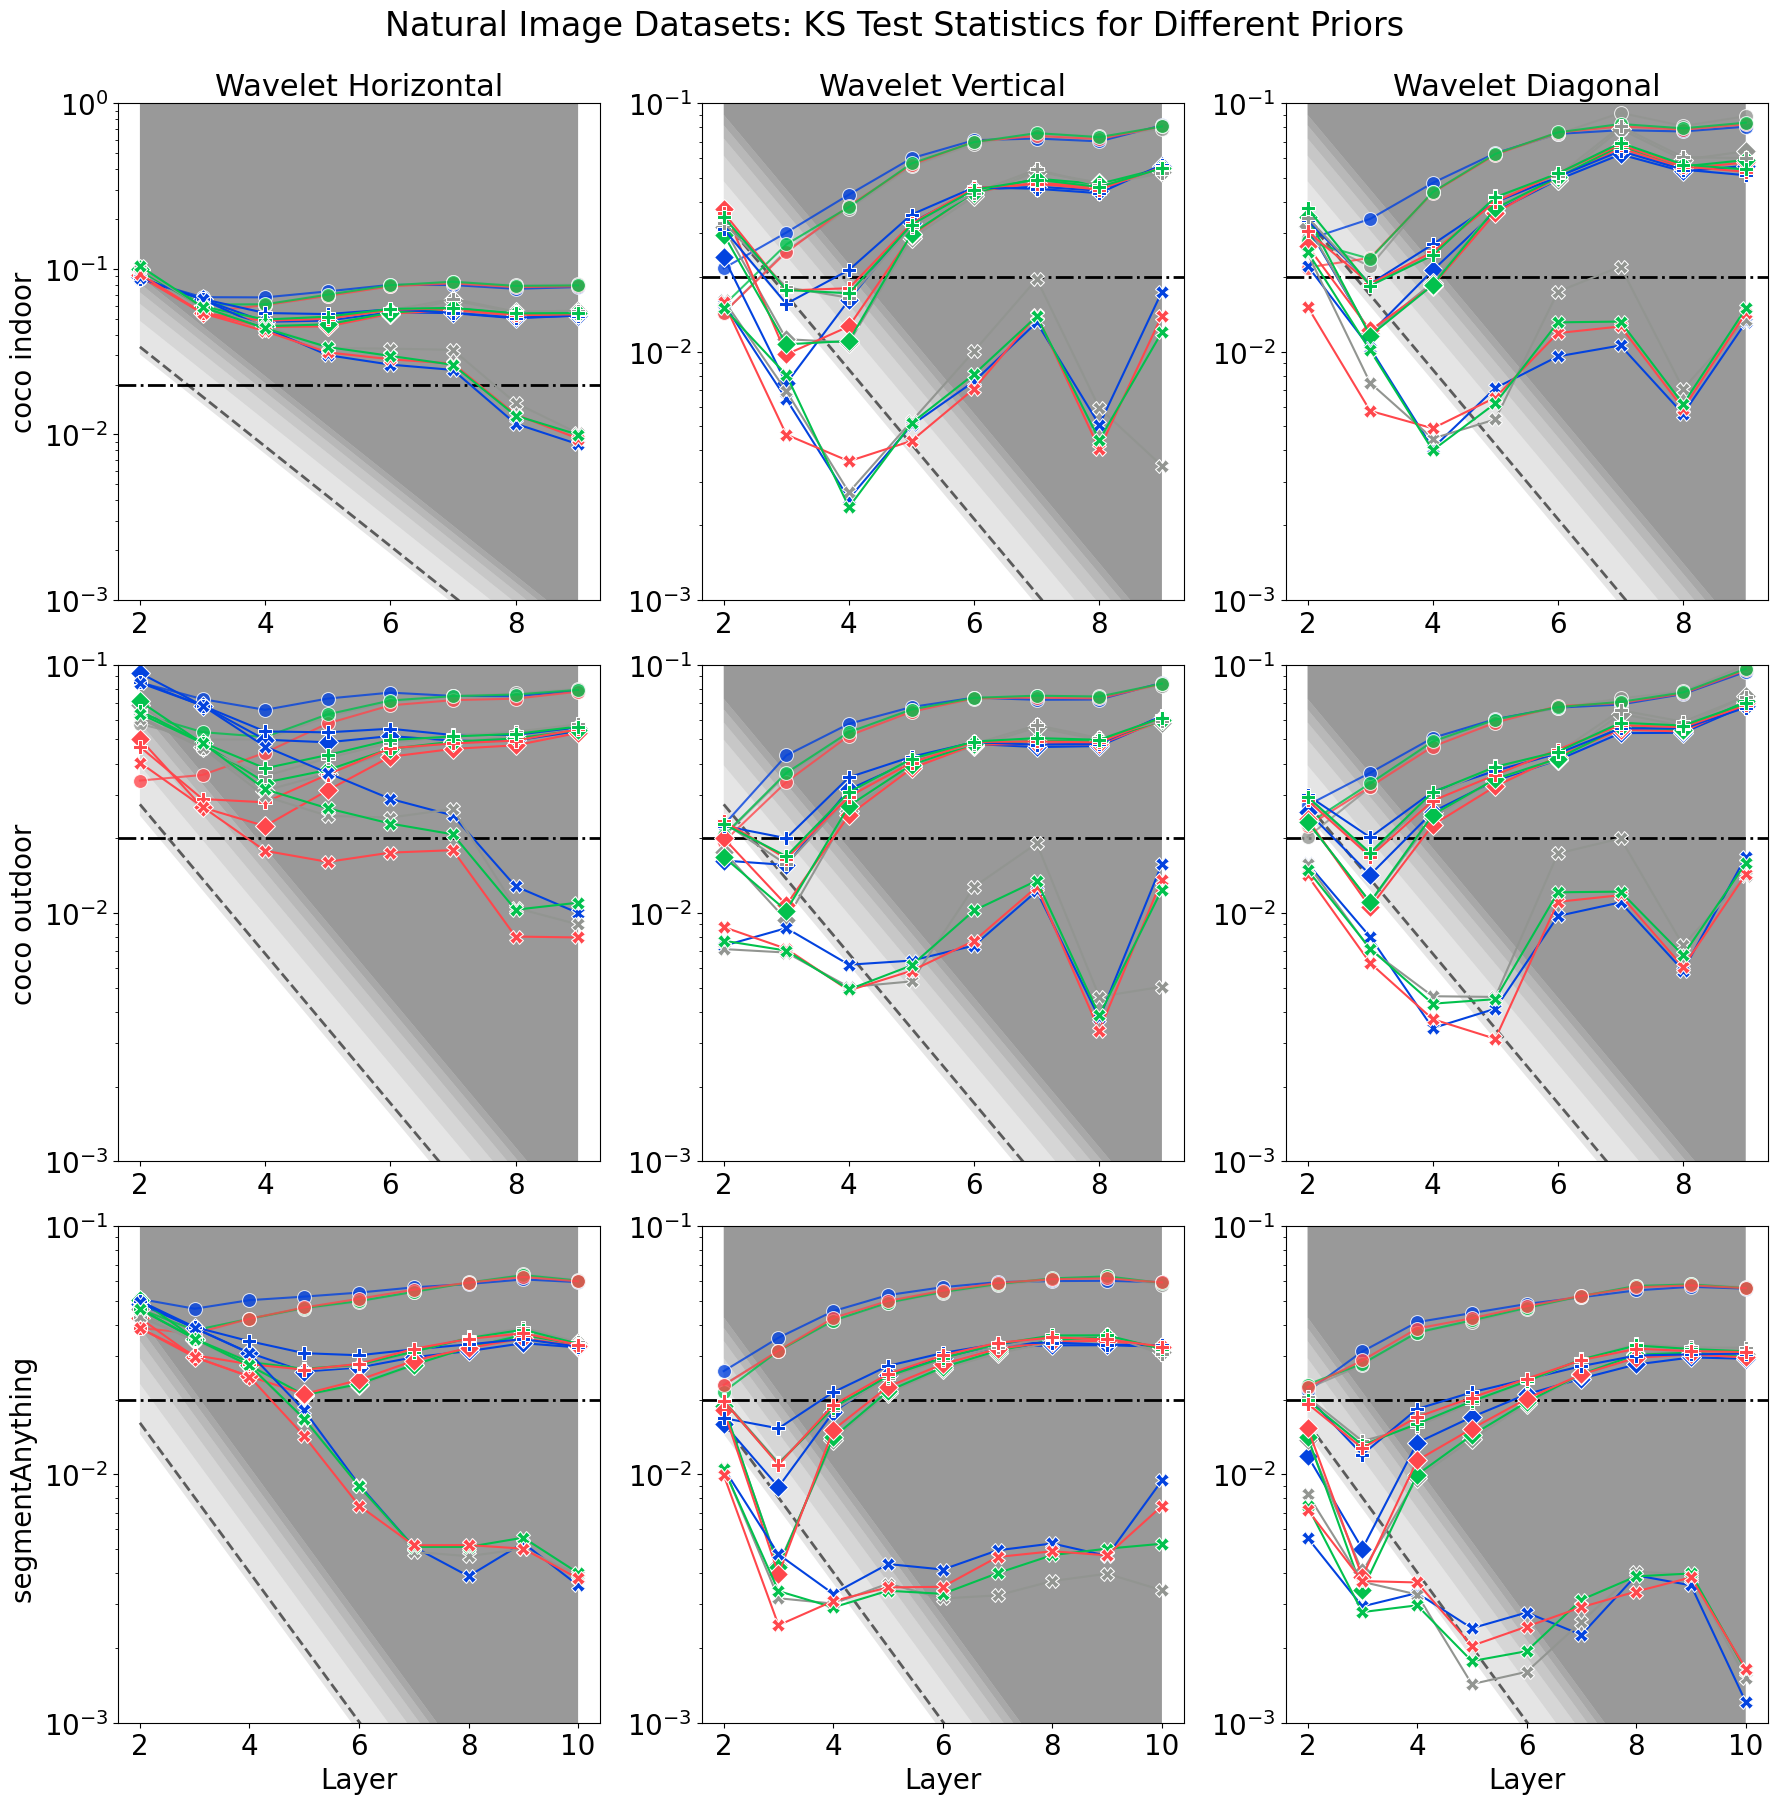

In [10]:
hue = 'channel'
fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}
toggle_markeredgecolor = True  # Set to True to enable markeredgecolor, False to disable
log_scale = not False
datasets_to_include = ['coco-indoor', 'coco-outdoor', 'segmentAnything-full']  # List of datasets to include
num_datasets = len(datasets_to_include)
marker_size = 10 

fig, axes = plt.subplots(num_datasets, 3, figsize=(18, 6 * num_datasets))

fig.suptitle("Natural Image Datasets: KS Test Statistics for Different Priors", y=1, fontsize=fontsize + 4)

for i, data_name in enumerate(datasets_to_include):
    hue = 'channel'
    fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}

    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    dataset_name, subset_name = data_name.split("-")
    dataset_filter = (main_df['dataset'] == dataset_name) & (main_df['subset'] == subset_name)
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'horizontal')
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    if log_scale:
        axes[i, 0].set_yscale('log')
        axes[i, 1].set_yscale('log')
        axes[i, 2].set_yscale('log')

    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 0].set_ylim(y_limits) 

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 0].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 0].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)
    
    # alpha=0.05
    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 0])
    
    # ks = 0.02
    axes[i, 0].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    # results
    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 0].set_xlabel("", fontsize=fontsize)
    axes[i, 0].set_ylabel(f"{dataset_name} {f'{(subset_name)}' if dataset_name == 'coco' else ''}", fontsize=fontsize)
    axes[i, 0].legend(points, labels, fontsize=12).set_visible(False) 
    axes[i, 0].tick_params(axis='both', which='major', labelsize=fontsize)

    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'vertical')
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 1].set_ylim(y_limits)  

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 1].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 1].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)

    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 1])

    axes[i, 1].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)
    
    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 1].set_xlabel("", fontsize=fontsize)
    axes[i, 1].set_ylabel("", fontsize=fontsize)
    axes[i, 1].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 1].tick_params(axis='both', which='major', labelsize=fontsize)

    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'diagonal')
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    y_limits = (10 ** np.floor(np.log10(np.min(np.array(temp.filter(regex='kstest_stat_\w+$'))))), 10 ** np.ceil(np.log10(np.max(np.array(temp.filter(regex='kstest_stat_\w+$')))))) 
    axes[i, 2].set_ylim(y_limits)

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[i, 2].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[i, 2].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)

    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[i, 2])

    axes[i, 2].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[i, 2].set_xlabel("", fontsize=fontsize)
    axes[i, 2].set_ylabel("", fontsize=fontsize)
    axes[i, 2].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 2].tick_params(axis='both', which='major', labelsize=fontsize)

axes[0, 0].set_title(f"Wavelet Horizontal", fontsize=fontsize + 2)
axes[0, 1].set_title(f"Wavelet Vertical", fontsize=fontsize + 2)
axes[0, 2].set_title(f"Wavelet Diagonal", fontsize=fontsize + 2)

axes[2, 0].set_xlabel("Layer", fontsize=fontsize)
axes[2, 1].set_xlabel("Layer", fontsize=fontsize)
axes[2, 2].set_xlabel("Layer", fontsize=fontsize)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "natural_images_ksstats.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')


# Medical Images

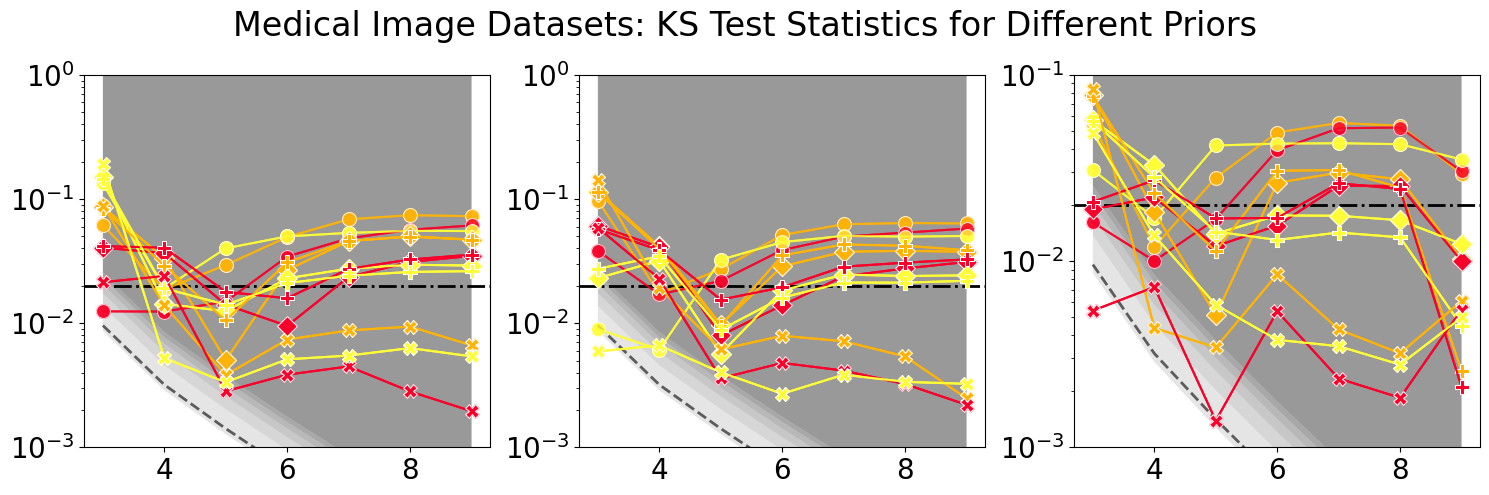

In [11]:
hue = 'subset'
fixed_palette = {'axial': 'xkcd:amber', 'coronal': 'xkcd:cherry red', 'sagittal': 'xkcd:sunshine yellow'}
log_scale = True
dataset_name = 'syntheticMRI2D'
orientations = ['horizontal', 'vertical', 'diagonal']  # List of subsets to include
num_subsets = len(orientations)
fig, axes = plt.subplots(1, num_subsets, figsize=(5 * num_subsets, 5))
marker_size = 10 

fig.suptitle("Medical Image Datasets: KS Test Statistics for Different Priors", fontsize=fontsize+4)

if num_subsets == 1:
    axes = [axes]

for j, orientation in enumerate(orientations):

    if log_scale:
        axes[j].set_yscale('log')

    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    dataset_filter = (main_df['dataset'] == dataset_name)
    transform_filter = (main_df['transform'] == transform) & (main_df['group'] > 2) & (main_df['orientation'] == orientation)
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    y_limits = (10 ** np.floor(np.log10(temp.filter(regex='kstest_stat_\w+$').min().min())), 
                10 ** np.ceil(np.log10(temp.filter(regex='kstest_stat_\w+$').max().max())))
    axes[j].set_ylim(y_limits)

    cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        axes[j].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
    axes[j].fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)


    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[j], markersize=marker_size, markeredgecolor=None)
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[j], markersize=marker_size, markeredgecolor=None)
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[j], markersize=marker_size, markeredgecolor=None)
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[j], markersize=marker_size, markeredgecolor=None)

    cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
    sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=axes[j])

    axes[j].axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    
    axes[j].set_xlabel("", fontsize=fontsize)
    axes[j].set_ylabel("", fontsize=fontsize)
    axes[j].legend(points, labels, fontsize=12).set_visible(False)
    axes[j].tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"{dataset_name}_ksstats.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')


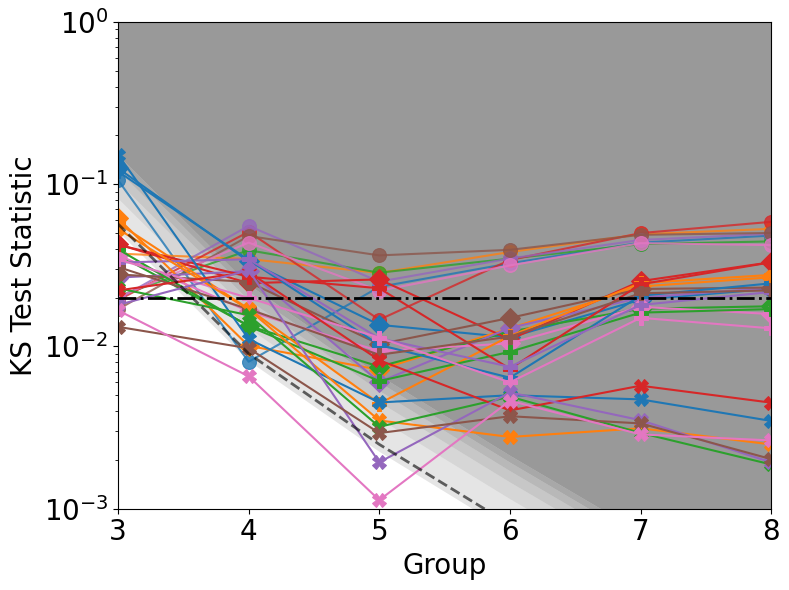

In [12]:
# Define a custom palette for orientations
orientation_palette = {
    'aad': 'xkcd:light green',
    'ada': 'xkcd:orange',
    'add': 'xkcd:green',
    'daa': 'xkcd:purple',
    'dad': 'xkcd:yellow',
    'dda': 'xkcd:red',
    'ddd': 'xkcd:dark blue'
}
orientation_palette=None

# Filter data for the dataset and subset
data_name = 'syntheticMRI3D'
dataset_filter = (main_df['dataset'] == data_name) & (main_df['subset'] == 'full')
transform_filter = (main_df['transform'] == 'wavelet')
temp = main_df[dataset_filter & transform_filter]
log_scale = True
hue = 'orientation'
marker_size = 10 

fig, ax = plt.subplots(figsize=(8, 6))

if log_scale:
    ax.set_yscale('log')

y_limits = (10 ** np.floor(np.log10(temp.filter(regex='kstest_stat_\w+$').min().min())), 
            10 ** np.ceil(np.log10(temp.filter(regex='kstest_stat_\w+$').max().max())))
ax.set_ylim(y_limits)
ax.set_xlim((3, 8))

cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
for k, alpha in enumerate(statistical_cutoffs[:-1]):
    ax.fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
ax.fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=orientation_palette, marker='o', alpha=0.8, ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=orientation_palette, marker='D', ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=orientation_palette, marker='P', ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=orientation_palette, marker='X', ax=ax, markersize=marker_size, markeredgecolor=None)

cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=ax)

ax.axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

ax.set_xlabel("Group", fontsize=fontsize)
ax.set_ylabel("KS Test Statistic", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=12).set_visible(False)

plt.tight_layout()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "syntheticMRI3D_ksstats.jpg")
    plt.savefig(save_path, dpi=600, bbox_inches='tight')

plt.show()


C:\Users\yashd\AppData\Local\Temp\ipykernel_46200\1627174084.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=12).set_visible(False)


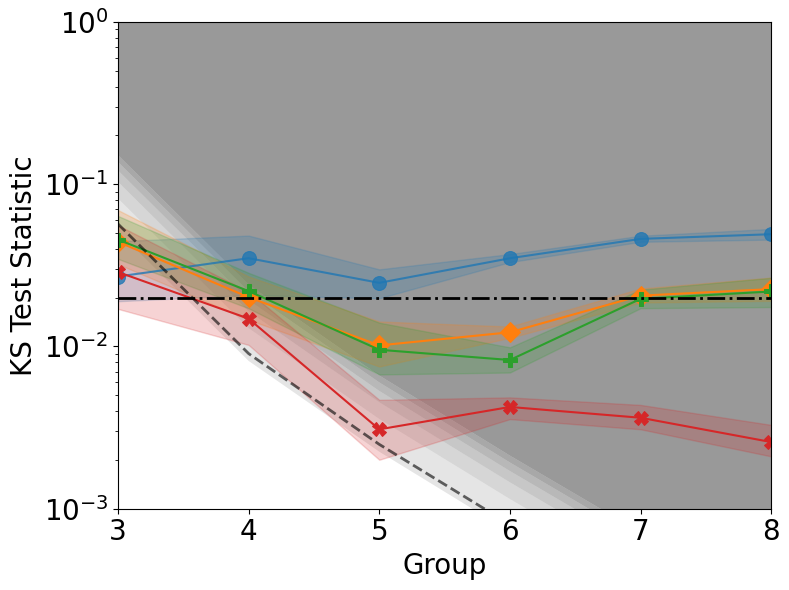

In [13]:
# Define a custom palette for orientations
orientation_palette = {
    'aad': 'xkcd:light green',
    'ada': 'xkcd:orange',
    'add': 'xkcd:green',
    'daa': 'xkcd:purple',
    'dad': 'xkcd:yellow',
    'dda': 'xkcd:red',
    'ddd': 'xkcd:dark blue'
}

# Filter data for the dataset and subset
data_name = 'syntheticMRI3D'
dataset_filter = (main_df['dataset'] == data_name) & (main_df['subset'] == 'full')
transform_filter = (main_df['transform'] == 'wavelet')
temp = main_df[dataset_filter & transform_filter]
log_scale = True
marker_size = 10 
# hue = 'orientation'

fig, ax = plt.subplots(figsize=(8, 6))

if log_scale:
    ax.set_yscale('log')

y_limits = (10 ** np.floor(np.log10(temp.filter(regex='kstest_stat_\w+$').min().min())), 
            10 ** np.ceil(np.log10(temp.filter(regex='kstest_stat_\w+$').max().max())))
ax.set_ylim(y_limits)
ax.set_xlim((3, 8))

cutoff = temp.groupby('group').agg({f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs}).reset_index()
for k, alpha in enumerate(statistical_cutoffs[:-1]):
    ax.fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'], color='black', alpha=alphas[k], ec=None)
ax.fill_between(cutoff['group'], cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'], y_limits[1], color='black', alpha=alphas[-1], ec=None)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', marker='o', alpha=0.8, ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', marker='D', ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', marker='P', ax=ax, markersize=marker_size, markeredgecolor=None)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', marker='X', ax=ax, markersize=marker_size, markeredgecolor=None)

cutoff_05 = temp.groupby('group').agg({f'kstest_stat_cutoff_0.05': 'first'}).reset_index()
sns.lineplot(x=cutoff['group'], y=cutoff_05['kstest_stat_cutoff_0.05'], linestyle="--", color='black', linewidth=2, alpha=0.6, ax=ax)

ax.axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

ax.set_xlabel("Group", fontsize=fontsize)
ax.set_ylabel("KS Test Statistic", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=12).set_visible(False)

plt.tight_layout()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "syntheticMRI3D_ksstats.jpg")
    plt.savefig(save_path, dpi=600, bbox_inches='tight')

plt.show()


# Learned Filters

In [14]:
nonskewed_df = pd.read_csv(os.path.join(ROOT_DIR, 'learned-filters', 'nonskewed_filter_idxs_df.csv')).set_index(['dataset', 'num_images', 'num_bootstrap'])
nonskewed_df = nonskewed_df.sort_values('num_images', ascending=False).groupby('dataset').first()
nonskewed_df['num_filters'] = nonskewed_df['nonskewed_filter_idxs'].apply(lambda x : len(eval(x)))
nonskewed_df

,nonskewed_filter_idxs,num_filters
dataset,,
agriVision-full,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",60
coco-indoor,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",62
coco-outdoor,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",64
pastis-full,"[2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18,...",35
segmentAnything-full,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",64
spaceNet-full,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",56


In [15]:
common_filter_idxs = set.intersection(*[set(eval(i)) for i in nonskewed_df['nonskewed_filter_idxs']])
print(len(common_filter_idxs))

35


In [16]:
filters = pd.read_pickle(os.path.join(ROOT_DIR, 'learned-filters', 'filters.pickle'))

In [17]:
fixed_palette = {'single_edge': 'red',
                'multi_edge': 'blue',
                'eye': 'xkcd:dark yellow',
                'dual_color': 'darkgreen',
                'inside_out': 'purple',
                'misc': 'orange'}

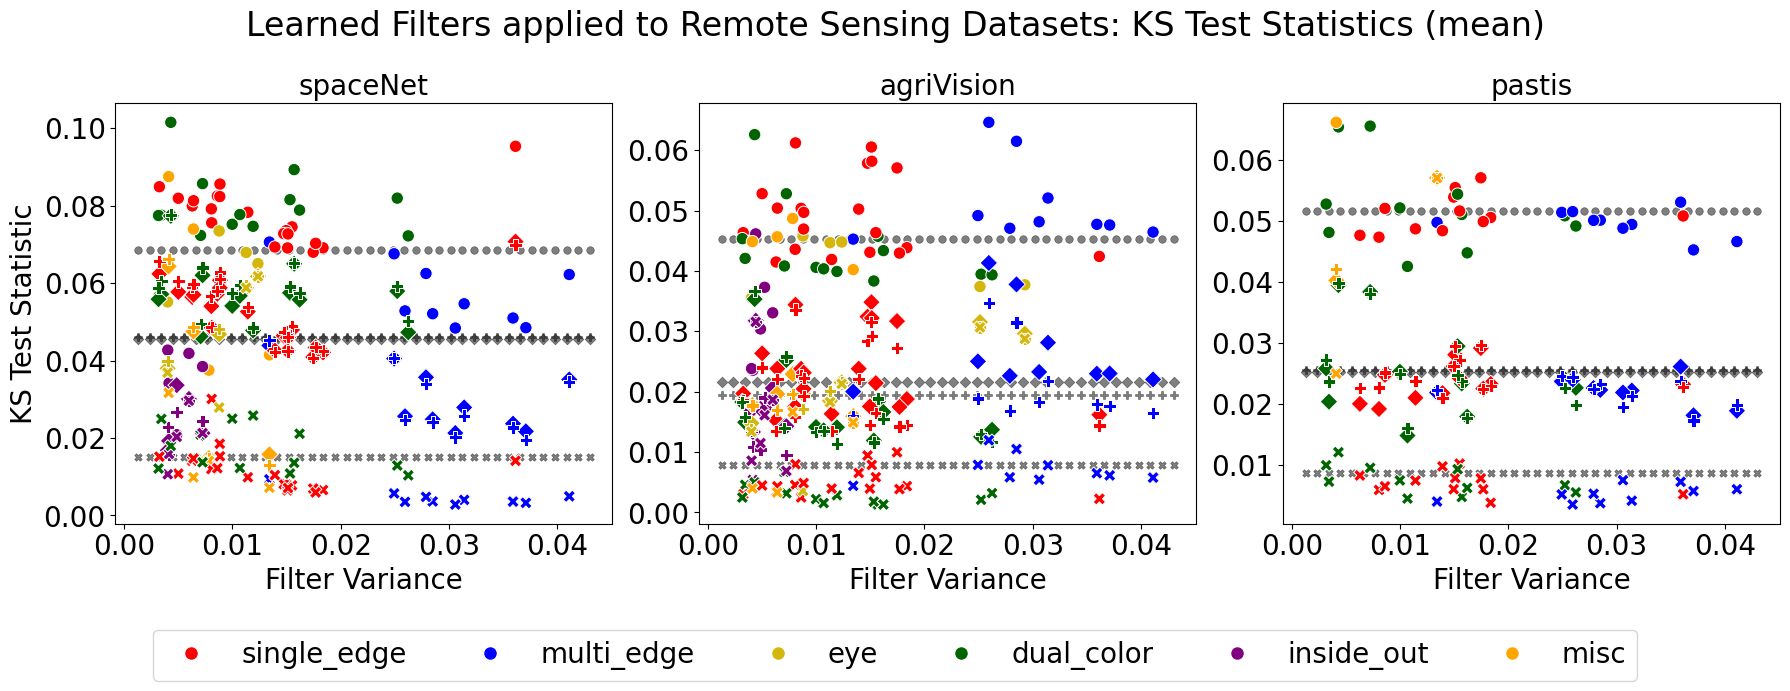

In [18]:
datasets_to_include = ['spaceNet', 'agriVision', 'pastis']
num_datasets = len(datasets_to_include)
transform='learned'
marker_size = 80

fig, axes = plt.subplots(1, num_datasets, figsize=(18, 6), sharey=False)
fig.suptitle("Learned Filters applied to Remote Sensing Datasets: KS Test Statistics (mean)", y=1, fontsize=fontsize + 4)

for i, dataset_name in enumerate(datasets_to_include):
    dataset_filter = (main_df['dataset'] == dataset_name)
    transform_filter = (main_df['transform'] == transform)
    temp = main_df[dataset_filter & transform_filter].copy()
    temp['filter_var'] = [np.var(filters[idx]) for idx in temp['group']]

    priors = ['kstest_stat_gaussian', 'kstest_stat_laplace', 'kstest_stat_t', 'kstest_stat_best']
    prior_markers = {'kstest_stat_gaussian': 'o', 'kstest_stat_laplace': 'D', 
                     'kstest_stat_t': 'P', 'kstest_stat_best': 'X'}
    
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_gaussian', hue='orientation', palette=fixed_palette, marker='o', ax=axes[i], s=marker_size, zorder=1)
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_laplace', hue='orientation', palette=fixed_palette, marker='D', ax=axes[i], s=marker_size, zorder=1)
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_t', hue='orientation', palette=fixed_palette, marker='P', ax=axes[i], s=marker_size, zorder=1)
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_best', hue='orientation', palette=fixed_palette, marker='X', ax=axes[i], s=marker_size, zorder=1)

    x_limits = axes[i].get_xlim()

    for prior in priors:
        median_value = temp[prior].mean()
        linestyle = {'kstest_stat_gaussian': '-', 'kstest_stat_laplace': '--', 
                     'kstest_stat_t': '-.', 'kstest_stat_best': ':'}[prior]
        sns.scatterplot(x=np.linspace(*x_limits, 40), y = median_value, marker=prior_markers[prior], ax=axes[i], s=30, color='black', zorder=0, ec=None, alpha=0.5)

    axes[i].set_ylabel("")
    axes[i].set_title(f"{dataset_name}", fontsize=fontsize)
    axes[i].set_xlabel("Filter Variance", fontsize=fontsize)
    axes[i].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[i].legend().set_visible(False)

axes[0].set_ylabel("KS Test Statistic", fontsize=fontsize)

# Custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='single_edge', markersize=10, markerfacecolor=fixed_palette['single_edge']),
                   Line2D([0], [0], marker='o', color='w', label='multi_edge', markersize=10, markerfacecolor=fixed_palette['multi_edge']),
                   Line2D([0], [0], marker='o', color='w', label='eye', markersize=10, markerfacecolor=fixed_palette['eye']),
                   Line2D([0], [0], marker='o', color='w', label='dual_color', markersize=10, markerfacecolor=fixed_palette['dual_color']),
                   Line2D([0], [0], marker='o', color='w', label='inside_out', markersize=10, markerfacecolor=fixed_palette['inside_out']),
                   Line2D([0], [0], marker='o', color='w', label='misc', markersize=10, markerfacecolor=fixed_palette['misc'])]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=6, fontsize=fontsize)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "learned_remote_sensing_ksstats_panel.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

C:\Users\yashd\AppData\Local\Temp\ipykernel_46200\3455097065.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_gaussian', hue='orientation', palette=fixed_palette, marker='o', ax=axes[i], s=marker_size, zorder=1, ec=None, alpha=0.5)
C:\Users\yashd\AppData\Local\Temp\ipykernel_46200\3455097065.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_laplace', hue='orientation', palette=fixed_palette, marker='D', ax=axes[i], s=marker_size, zorder=1, ec=None, alpha=0.5)
C:\Users\yashd\AppData\Local\Temp\ipykernel_46200\3455097065.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_t', hue='orientation', palette=fixed_palette, marker='P', ax=axes[i], s=marker_size, zorder=1, ec=None, alpha=0.5)
C:\Users\yashd\AppData\Loca

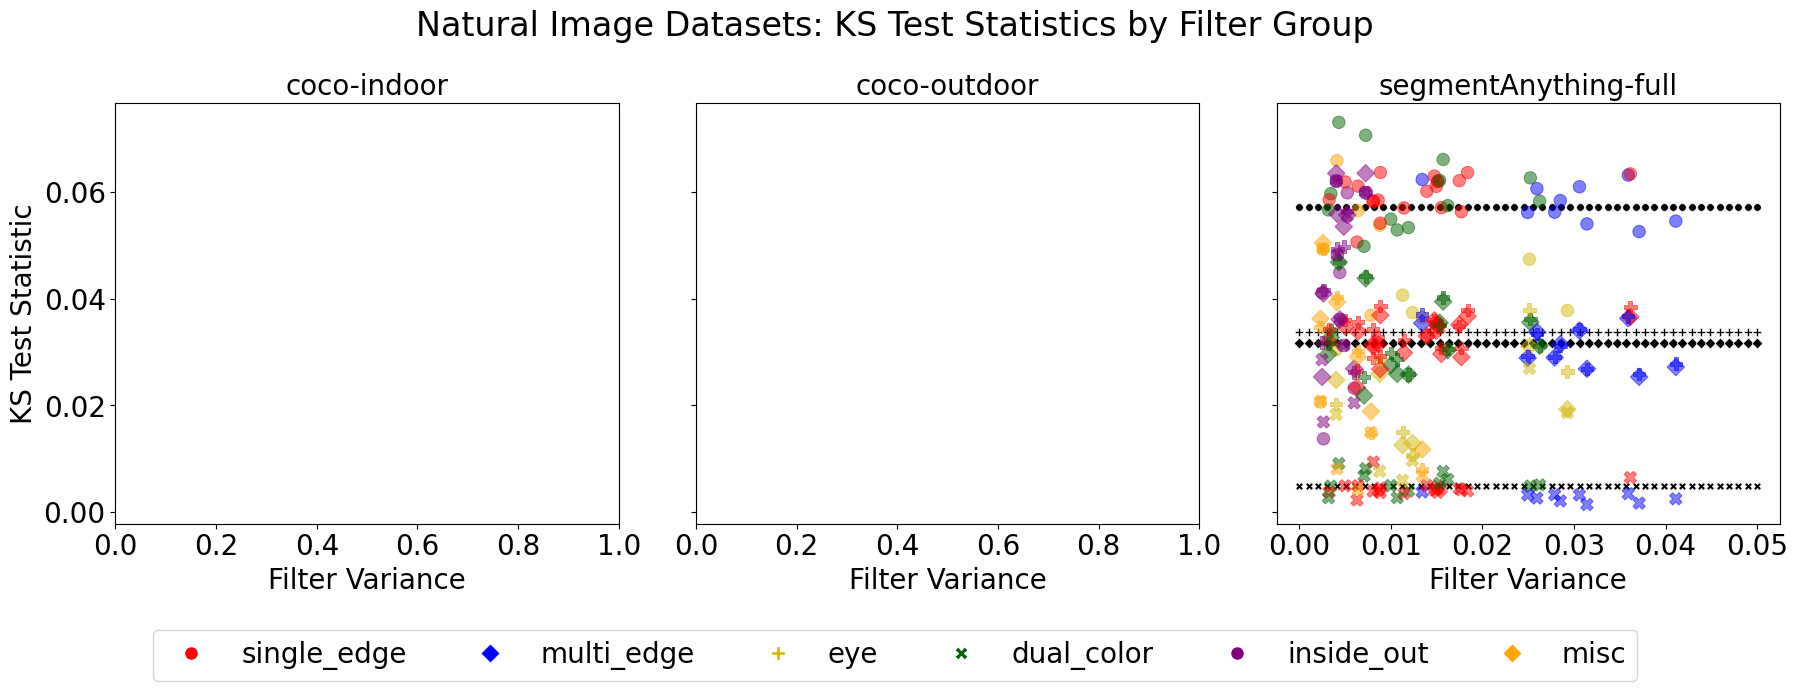

In [19]:
datasets_to_include = ['coco-indoor', 'coco-outdoor', 'segmentAnything-full']
num_datasets = len(datasets_to_include)
marker_size = 80

fig, axes = plt.subplots(1, num_datasets, figsize=(18, 6), sharey=True)
fig.suptitle("Natural Image Datasets: KS Test Statistics by Filter Group", y=1, fontsize=fontsize + 4)

for i, dataset_name in enumerate(datasets_to_include):
    dataset_filter = (main_df['dataset'] == dataset_name.split('-')[0]) & (main_df['subset'] == dataset_name.split('-')[1])
    transform_filter = (main_df['transform'] == transform)
    temp = main_df[dataset_filter & transform_filter].copy()
    temp['filter_var'] = [np.var(filters[idx]) for idx in temp['group']]

    priors = ['kstest_stat_gaussian', 'kstest_stat_laplace', 'kstest_stat_t', 'kstest_stat_best']
    prior_markers = {'kstest_stat_gaussian': 'o', 'kstest_stat_laplace': 'D', 
                     'kstest_stat_t': 'P', 'kstest_stat_best': 'X'}
    
    x_limits = (0, 0.05)

    for prior in priors:
        median_value = temp[prior].median()
        linestyle = {'kstest_stat_gaussian': '-', 'kstest_stat_laplace': '--', 
                     'kstest_stat_t': '-.', 'kstest_stat_best': ':'}[prior]
        sns.scatterplot(x=np.linspace(*x_limits, 50), y = median_value, marker=prior_markers[prior], ax=axes[i], s=30, color='black', zorder=0)

    
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_gaussian', hue='orientation', palette=fixed_palette, marker='o', ax=axes[i], s=marker_size, zorder=1, ec=None, alpha=0.5)
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_laplace', hue='orientation', palette=fixed_palette, marker='D', ax=axes[i], s=marker_size, zorder=1, ec=None, alpha=0.5)
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_t', hue='orientation', palette=fixed_palette, marker='P', ax=axes[i], s=marker_size, zorder=1, ec=None, alpha=0.5)
    sns.scatterplot(data=temp, x='filter_var', y='kstest_stat_best', hue='orientation', palette=fixed_palette, marker='X', ax=axes[i], s=marker_size, zorder=1, ec=None, alpha=0.5)
    
    axes[i].set_title(f"{dataset_name}", fontsize=fontsize)
    axes[i].set_xlabel("Filter Variance", fontsize=fontsize)
    axes[i].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[i].legend().set_visible(False)

axes[0].set_ylabel("KS Test Statistic", fontsize=fontsize)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='single_edge', markersize=10, markerfacecolor=fixed_palette['single_edge']),
                   Line2D([0], [0], marker='D', color='w', label='multi_edge', markersize=10, markerfacecolor=fixed_palette['multi_edge']),
                   Line2D([0], [0], marker='P', color='w', label='eye', markersize=10, markerfacecolor=fixed_palette['eye']),
                   Line2D([0], [0], marker='X', color='w', label='dual_color', markersize=10, markerfacecolor=fixed_palette['dual_color']),
                   Line2D([0], [0], marker='o', color='w', label='inside_out', markersize=10, markerfacecolor=fixed_palette['inside_out']),
                   Line2D([0], [0], marker='D', color='w', label='misc', markersize=10, markerfacecolor=fixed_palette['misc'])]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=6, fontsize=fontsize)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "learned_natural_images_ksstats_panel.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')
